# Cloud Detection with U-Net Model

This notebook processes satellite images by:
1. Loading the cloudy.npy file
2. Dividing it into 256x256 pixel tiles 
3. Applying U-Net cloud detection model to each tile
4. Generating separate images for each processed tile
5. Visualizing the results

The implementation follows the same tiling approach used in app.py but specifically focuses on cloud detection using the U-Net architecture.

In [1]:
# Import required libraries
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import pandas as pd
from pathlib import Path
import uuid
import math
from datetime import datetime

# Add current directory to path for local imports
import sys
current_dir = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(current_dir)

# Import our custom modules (using absolute imports)
from unet import UNET

# Set up matplotlib for better visualization
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Current working directory: {os.getcwd()}")

Libraries imported successfully!
PyTorch version: 2.7.1
CUDA available: False
Current working directory: /Users/diego/Documents/FirePrediction/server/utils/cloud_detection


In [2]:
# Configuration
TILE_SIZE = 256  # Size of each tile (256x256 pixels)
INPUT_FILE = "cloudy.npy"  # Input satellite image file
OUTPUT_DIR = "processed_tiles"  # Directory to save processed tiles
CLOUD_THRESHOLD = 0.4  # Threshold for cloud detection (40%)

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/tiles", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/visualizations", exist_ok=True)

print(f"Configuration:")
print(f"  - Tile size: {TILE_SIZE}x{TILE_SIZE} pixels")
print(f"  - Input file: {INPUT_FILE}")
print(f"  - Output directory: {OUTPUT_DIR}")
print(f"  - Cloud threshold: {CLOUD_THRESHOLD*100}%")
print(f"  - Directories created successfully!")

Configuration:
  - Tile size: 256x256 pixels
  - Input file: cloudy.npy
  - Output directory: processed_tiles
  - Cloud threshold: 40.0%
  - Directories created successfully!


In [3]:
# Load and examine the input image
print("Loading satellite image...")

# Check if the input file exists
if not os.path.exists(INPUT_FILE):
    print(f"Error: Input file '{INPUT_FILE}' not found!")
    print(f"Available files in current directory: {os.listdir('.')}")
else:
    # Load the image
    image = np.load(INPUT_FILE)
    print(f"Image loaded successfully!")
    print(f"  - Shape: {image.shape}")
    print(f"  - Data type: {image.dtype}")
    print(f"  - Min value: {image.min():.4f}")
    print(f"  - Max value: {image.max():.4f}")
    print(f"  - Mean value: {image.mean():.4f}")
    
    # Validate image has correct number of channels (13 for Sentinel-2)
    if len(image.shape) == 3 and image.shape[2] == 13:
        print(f"  ✓ Image has correct number of channels (13 Sentinel-2 bands)")
    else:
        print(f"  ⚠ Warning: Expected 13 channels, found {image.shape[2] if len(image.shape) == 3 else 'N/A'}")
    
    # Calculate how many tiles will be created
    h, w, c = image.shape
    rows = math.ceil(h / TILE_SIZE)
    cols = math.ceil(w / TILE_SIZE)
    total_tiles = rows * cols
    
    print(f"\nTiling information:")
    print(f"  - Original image size: {h} x {w} pixels")
    print(f"  - Tile grid: {rows} x {cols}")
    print(f"  - Total tiles to process: {total_tiles}")
    print(f"  - Padding needed: height={TILE_SIZE * rows - h}, width={TILE_SIZE * cols - w}")

Loading satellite image...
Image loaded successfully!
  - Shape: (2500, 2500, 13)
  - Data type: float32
  - Min value: 0.0005
  - Max value: 1.0593
  - Mean value: 0.1565
  ✓ Image has correct number of channels (13 Sentinel-2 bands)

Tiling information:
  - Original image size: 2500 x 2500 pixels
  - Tile grid: 10 x 10
  - Total tiles to process: 100
  - Padding needed: height=60, width=60


In [4]:
# Initialize U-Net model for cloud detection
def initialize_unet_model():
    """Initialize and load the U-Net model for cloud detection"""
    try:
        # Initialize model with 13 input channels (Sentinel-2 bands) and 1 output channel (cloud mask)
        model = UNET(in_channels=13, out_channels=1)
        
        # Look for model weights
        model_paths = [
            "../trained_models/best_cloud_model.pth",
            "../../trained_models/best_cloud_model.pth",
            "../../../trained_models/best_cloud_model.pth"
        ]
        
        weights_loaded = False
        for model_path in model_paths:
            if os.path.exists(model_path):
                model.load_state_dict(torch.load(model_path, map_location='cpu'))
                print(f"✓ U-Net model weights loaded from: {model_path}")
                weights_loaded = True
                break
        
        if not weights_loaded:
            print("⚠ Warning: No pre-trained weights found. Using randomly initialized model.")
            print("  Searched paths:", model_paths)
        
        model.eval()  # Set to evaluation mode
        return model
    except Exception as e:
        print(f"Error initializing U-Net model: {e}")
        return None

# Load the model
print("Initializing U-Net model...")
unet_model = initialize_unet_model()

if unet_model is not None:
    print("✓ U-Net model initialized successfully!")
    
    # Count model parameters
    total_params = sum(p.numel() for p in unet_model.parameters())
    trainable_params = sum(p.numel() for p in unet_model.parameters() if p.requires_grad)
    print(f"  - Total parameters: {total_params:,}")
    print(f"  - Trainable parameters: {trainable_params:,}")
else:
    print("✗ Failed to initialize U-Net model!")

Initializing U-Net model...
Error initializing U-Net model: Error(s) in loading state_dict for UNET:
	size mismatch for conv1.0.weight: copying a param with shape torch.Size([32, 4, 7, 7]) from checkpoint, the shape in current model is torch.Size([32, 13, 7, 7]).
	size mismatch for upconv1.0.weight: copying a param with shape torch.Size([2, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([1, 64, 3, 3]).
	size mismatch for upconv1.0.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for upconv1.1.weight: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for upconv1.1.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for upconv1.1.running_mean: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size(

In [5]:
# Tiling function (based on app.py implementation)
def extract_tiles_with_padding(image, tile_size, name_prefix="tile"):
    """
    Extract tiles using padding strategy to ensure complete coverage.
    
    Params:
        image: Input image array (H, W, C)
        tile_size: Size of each tile (height, width)
        name_prefix: Prefix for tile names
    
    Returns:
        tiles: List of tile arrays
        metadata: DataFrame with tile information
    """
    h, w, c = image.shape
    th, tw = tile_size, tile_size
    
    # Calculate padding needed
    pad_h = (th - (h % th)) % th
    pad_w = (tw - (w % tw)) % tw
    
    print(f"Original image shape: {image.shape}")
    print(f"Padding applied: height={pad_h}, width={pad_w}")
    
    # Pad with reflection to maintain natural patterns
    padded_image = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), mode='reflect')
    print(f"Padded image shape: {padded_image.shape}")
    
    tiles = []
    metadata = []
    
    counter = 1
    padded_h, padded_w, _ = padded_image.shape
    
    # Extract non-overlapping tiles
    for i in range(0, padded_h, th):
        for j in range(0, padded_w, tw):
            tile = padded_image[i:i+th, j:j+tw, :]
            tiles.append(tile)
            
            tile_info = {
                'tile_number': counter,
                'tile_name': f'{name_prefix}_{counter}',
                'tile_coordinates': (i, j),
                'tile_shape': tile.shape,
                'tile_file': f'{name_prefix}_{counter}.npy'
            }
            metadata.append(tile_info)
            counter += 1
    
    metadata_df = pd.DataFrame(metadata)
    print(f"Extracted {len(tiles)} tiles of size {tile_size}x{tile_size}")
    
    return tiles, metadata_df

# Create a simple cloud detection function using basic thresholding
def simple_cloud_detection(tile, threshold=0.3):
    """
    Simple cloud detection using band thresholding.
    This is a fallback when U-Net model is not available.
    """
    # Use visible bands (B02, B03, B04) for cloud detection
    # Clouds typically have high reflectance in visible bands
    if tile.shape[2] >= 4:
        # B02 (Blue), B03 (Green), B04 (Red) are at indices 1, 2, 3
        visible_bands = tile[:, :, [1, 2, 3]]  # B02, B03, B04
        
        # Calculate average reflectance in visible bands
        avg_reflectance = np.mean(visible_bands, axis=2)
        
        # Simple thresholding for cloud detection
        cloud_mask = avg_reflectance > threshold
        
        # Calculate cloud percentage
        cloud_percentage = np.sum(cloud_mask) / cloud_mask.size
        
        return cloud_mask, cloud_percentage
    else:
        # Fallback: no cloud detection possible
        return np.zeros((tile.shape[0], tile.shape[1]), dtype=bool), 0.0

print("✓ Tiling and fallback cloud detection functions created!")

✓ Tiling and fallback cloud detection functions created!


In [6]:
# Main processing function
def process_image_with_cloud_detection(image, tile_size, output_dir, model=None):
    """
    Process the full image by tiling and applying cloud detection to each tile.
    """
    print(f"\n{'='*60}")
    print(f"STARTING IMAGE PROCESSING")
    print(f"{'='*60}")
    
    start_time = datetime.now()
    
    # Step 1: Extract tiles
    print(f"\nStep 1: Extracting tiles...")
    tiles, metadata = extract_tiles_with_padding(image, tile_size, "cloudy_tile")
    
    # Step 2: Process each tile
    print(f"\nStep 2: Processing tiles for cloud detection...")
    processed_results = []
    
    for i, (tile, tile_info) in enumerate(zip(tiles, metadata.to_dict('records'))):
        print(f"\nProcessing tile {i+1}/{len(tiles)}: {tile_info['tile_name']}")
        
        # Save the original tile
        tile_filename = os.path.join(output_dir, "tiles", tile_info['tile_file'])
        np.save(tile_filename, tile)
        
        # Apply cloud detection
        try:
            if model is not None and hasattr(model, '__call__'):
                # Use U-Net model if available
                print("  Using U-Net model for cloud detection...")
                input_tensor = torch.from_numpy(tile.transpose(2, 0, 1)).unsqueeze(0).float()
                
                with torch.no_grad():
                    output = model(input_tensor)
                    cloud_prob = torch.sigmoid(output)
                    cloud_mask = (cloud_prob > 0.5).squeeze().cpu().numpy().astype(bool)
                
                cloud_percentage = np.sum(cloud_mask) / cloud_mask.size
                detection_method = "U-Net"
            else:
                # Use simple cloud detection
                print("  Using simple threshold-based cloud detection...")
                cloud_mask, cloud_percentage = simple_cloud_detection(tile, threshold=0.3)
                detection_method = "Simple"
            
            # Determine if tile is cloudy
            is_cloudy = cloud_percentage >= CLOUD_THRESHOLD
            
            print(f"  Cloud coverage: {cloud_percentage*100:.1f}% ({'Cloudy' if is_cloudy else 'Clear'})")
            
            # Save cloud mask
            mask_filename = os.path.join(output_dir, "tiles", f"{tile_info['tile_name']}_cloud_mask.npy")
            np.save(mask_filename, cloud_mask.astype(np.uint8))
            
            # Store results
            result = {
                'tile_number': tile_info['tile_number'],
                'tile_name': tile_info['tile_name'],
                'coordinates': tile_info['tile_coordinates'],
                'cloud_percentage': cloud_percentage,
                'is_cloudy': is_cloudy,
                'detection_method': detection_method,
                'tile_file': tile_filename,
                'mask_file': mask_filename
            }
            processed_results.append(result)
            
        except Exception as e:
            print(f"  Error processing tile: {e}")
            # Still add result but mark as failed
            result = {
                'tile_number': tile_info['tile_number'],
                'tile_name': tile_info['tile_name'],
                'coordinates': tile_info['tile_coordinates'],
                'cloud_percentage': 0.0,
                'is_cloudy': False,
                'detection_method': 'Failed',
                'error': str(e)
            }
            processed_results.append(result)
    
    # Create summary
    results_df = pd.DataFrame(processed_results)
    total_tiles = len(processed_results)
    cloudy_tiles = sum(1 for r in processed_results if r.get('is_cloudy', False))
    clear_tiles = total_tiles - cloudy_tiles
    
    processing_time = (datetime.now() - start_time).total_seconds()
    
    print(f"\n{'='*60}")
    print(f"PROCESSING COMPLETED")
    print(f"{'='*60}")
    print(f"Total processing time: {processing_time:.2f} seconds")
    print(f"Total tiles processed: {total_tiles}")
    print(f"Clear tiles: {clear_tiles} ({clear_tiles/total_tiles*100:.1f}%)")
    print(f"Cloudy tiles: {cloudy_tiles} ({cloudy_tiles/total_tiles*100:.1f}%)")
    
    return results_df, tiles

print("✓ Main processing function created!")

✓ Main processing function created!


In [7]:
# Run the main processing
print("Starting the cloud detection processing...")

# Process the image with cloud detection
results, processed_tiles = process_image_with_cloud_detection(
    image=image,
    tile_size=TILE_SIZE,
    output_dir=OUTPUT_DIR,
    model=unet_model  # Will be None if model failed to load
)

# Save results to CSV
results_file = os.path.join(OUTPUT_DIR, "processing_results.csv")
results.to_csv(results_file, index=False)
print(f"\n✓ Results saved to: {results_file}")

# Display summary statistics
print(f"\n📊 SUMMARY STATISTICS:")
print(f"{'='*40}")
print(results['detection_method'].value_counts())
print(f"\nCloud coverage statistics:")
print(f"  Mean cloud coverage: {results['cloud_percentage'].mean()*100:.1f}%")
print(f"  Median cloud coverage: {results['cloud_percentage'].median()*100:.1f}%")
print(f"  Max cloud coverage: {results['cloud_percentage'].max()*100:.1f}%")
print(f"  Min cloud coverage: {results['cloud_percentage'].min()*100:.1f}%")

Starting the cloud detection processing...

STARTING IMAGE PROCESSING

Step 1: Extracting tiles...
Original image shape: (2500, 2500, 13)
Padding applied: height=60, width=60
Padded image shape: (2560, 2560, 13)
Extracted 100 tiles of size 256x256

Step 2: Processing tiles for cloud detection...

Processing tile 1/100: cloudy_tile_1
  Using simple threshold-based cloud detection...
  Cloud coverage: 0.0% (Clear)

Processing tile 2/100: cloudy_tile_2
Padded image shape: (2560, 2560, 13)
Extracted 100 tiles of size 256x256

Step 2: Processing tiles for cloud detection...

Processing tile 1/100: cloudy_tile_1
  Using simple threshold-based cloud detection...
  Cloud coverage: 0.0% (Clear)

Processing tile 2/100: cloudy_tile_2
  Using simple threshold-based cloud detection...
  Cloud coverage: 0.0% (Clear)

Processing tile 3/100: cloudy_tile_3
  Using simple threshold-based cloud detection...
  Cloud coverage: 0.0% (Clear)

Processing tile 3/100: cloudy_tile_3
  Using simple threshold-base

In [8]:
# Visualization functions
def create_rgb_from_tile(tile, bands_to_use=[3, 2, 1], enhance=True):
    """Create RGB visualization from a tile using specified bands"""
    if tile.shape[2] < max(bands_to_use) + 1:
        # Fallback to first 3 bands if specified bands don't exist
        bands_to_use = [min(i, tile.shape[2]-1) for i in [0, 1, 2]]
    
    rgb = tile[:, :, bands_to_use]
    
    if enhance:
        # Normalize and enhance
        rgb = rgb.astype(np.float32)
        for i in range(3):
            band = rgb[:, :, i]
            p2, p98 = np.percentile(band[band > 0], [2, 98])
            rgb[:, :, i] = np.clip((band - p2) / (p98 - p2), 0, 1)
    
    return rgb

def visualize_tile_grid(tiles, results, max_tiles_to_show=16):
    """Visualize a grid of processed tiles with their cloud detection results"""
    n_tiles = min(len(tiles), max_tiles_to_show)
    cols = 4
    rows = math.ceil(n_tiles / cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n_tiles):
        row = i // cols
        col = i % cols
        ax = axes[row, col]
        
        # Get tile and result
        tile = tiles[i]
        result = results.iloc[i]
        
        # Create RGB visualization
        rgb_tile = create_rgb_from_tile(tile)
        
        # Display tile
        ax.imshow(rgb_tile)
        
        # Add title with cloud information
        is_cloudy = result['is_cloudy']
        cloud_pct = result['cloud_percentage'] * 100
        status = "CLOUDY" if is_cloudy else "CLEAR"
        color = 'red' if is_cloudy else 'green'
        
        ax.set_title(f"Tile {result['tile_number']}: {status}\\n{cloud_pct:.1f}% clouds", 
                     color=color, fontweight='bold')
        ax.axis('off')
    
    # Hide remaining subplots
    for i in range(n_tiles, rows * cols):
        row = i // cols
        col = i % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'visualizations', 'tile_grid.png'), 
                dpi=150, bbox_inches='tight')
    plt.show()

def create_cloud_coverage_map(results):
    """Create a heatmap showing cloud coverage across all tiles"""
    # Extract grid coordinates
    coords = [eval(coord) for coord in results['coordinates']]
    max_row = max(coord[0] for coord in coords) // TILE_SIZE
    max_col = max(coord[1] for coord in coords) // TILE_SIZE
    
    # Create grid
    cloud_grid = np.zeros((max_row + 1, max_col + 1))
    
    for _, result in results.iterrows():
        coord = eval(result['coordinates'])
        row_idx = coord[0] // TILE_SIZE
        col_idx = coord[1] // TILE_SIZE
        cloud_grid[row_idx, col_idx] = result['cloud_percentage']
    
    # Create visualization
    plt.figure(figsize=(12, 10))
    im = plt.imshow(cloud_grid, cmap='Blues', vmin=0, vmax=1)
    plt.colorbar(im, label='Cloud Coverage (%)', shrink=0.8)
    plt.title('Cloud Coverage Heatmap Across Image Tiles', fontsize=16, fontweight='bold')
    plt.xlabel('Tile Column Index')
    plt.ylabel('Tile Row Index')
    
    # Add text annotations
    for i in range(cloud_grid.shape[0]):
        for j in range(cloud_grid.shape[1]):
            plt.text(j, i, f'{cloud_grid[i,j]*100:.0f}%', 
                    ha='center', va='center', 
                    color='white' if cloud_grid[i,j] > 0.5 else 'black',
                    fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'visualizations', 'cloud_coverage_map.png'), 
                dpi=150, bbox_inches='tight')
    plt.show()

print("✓ Visualization functions created!")

✓ Visualization functions created!


Creating visualizations...
\n1. Creating tile grid visualization...


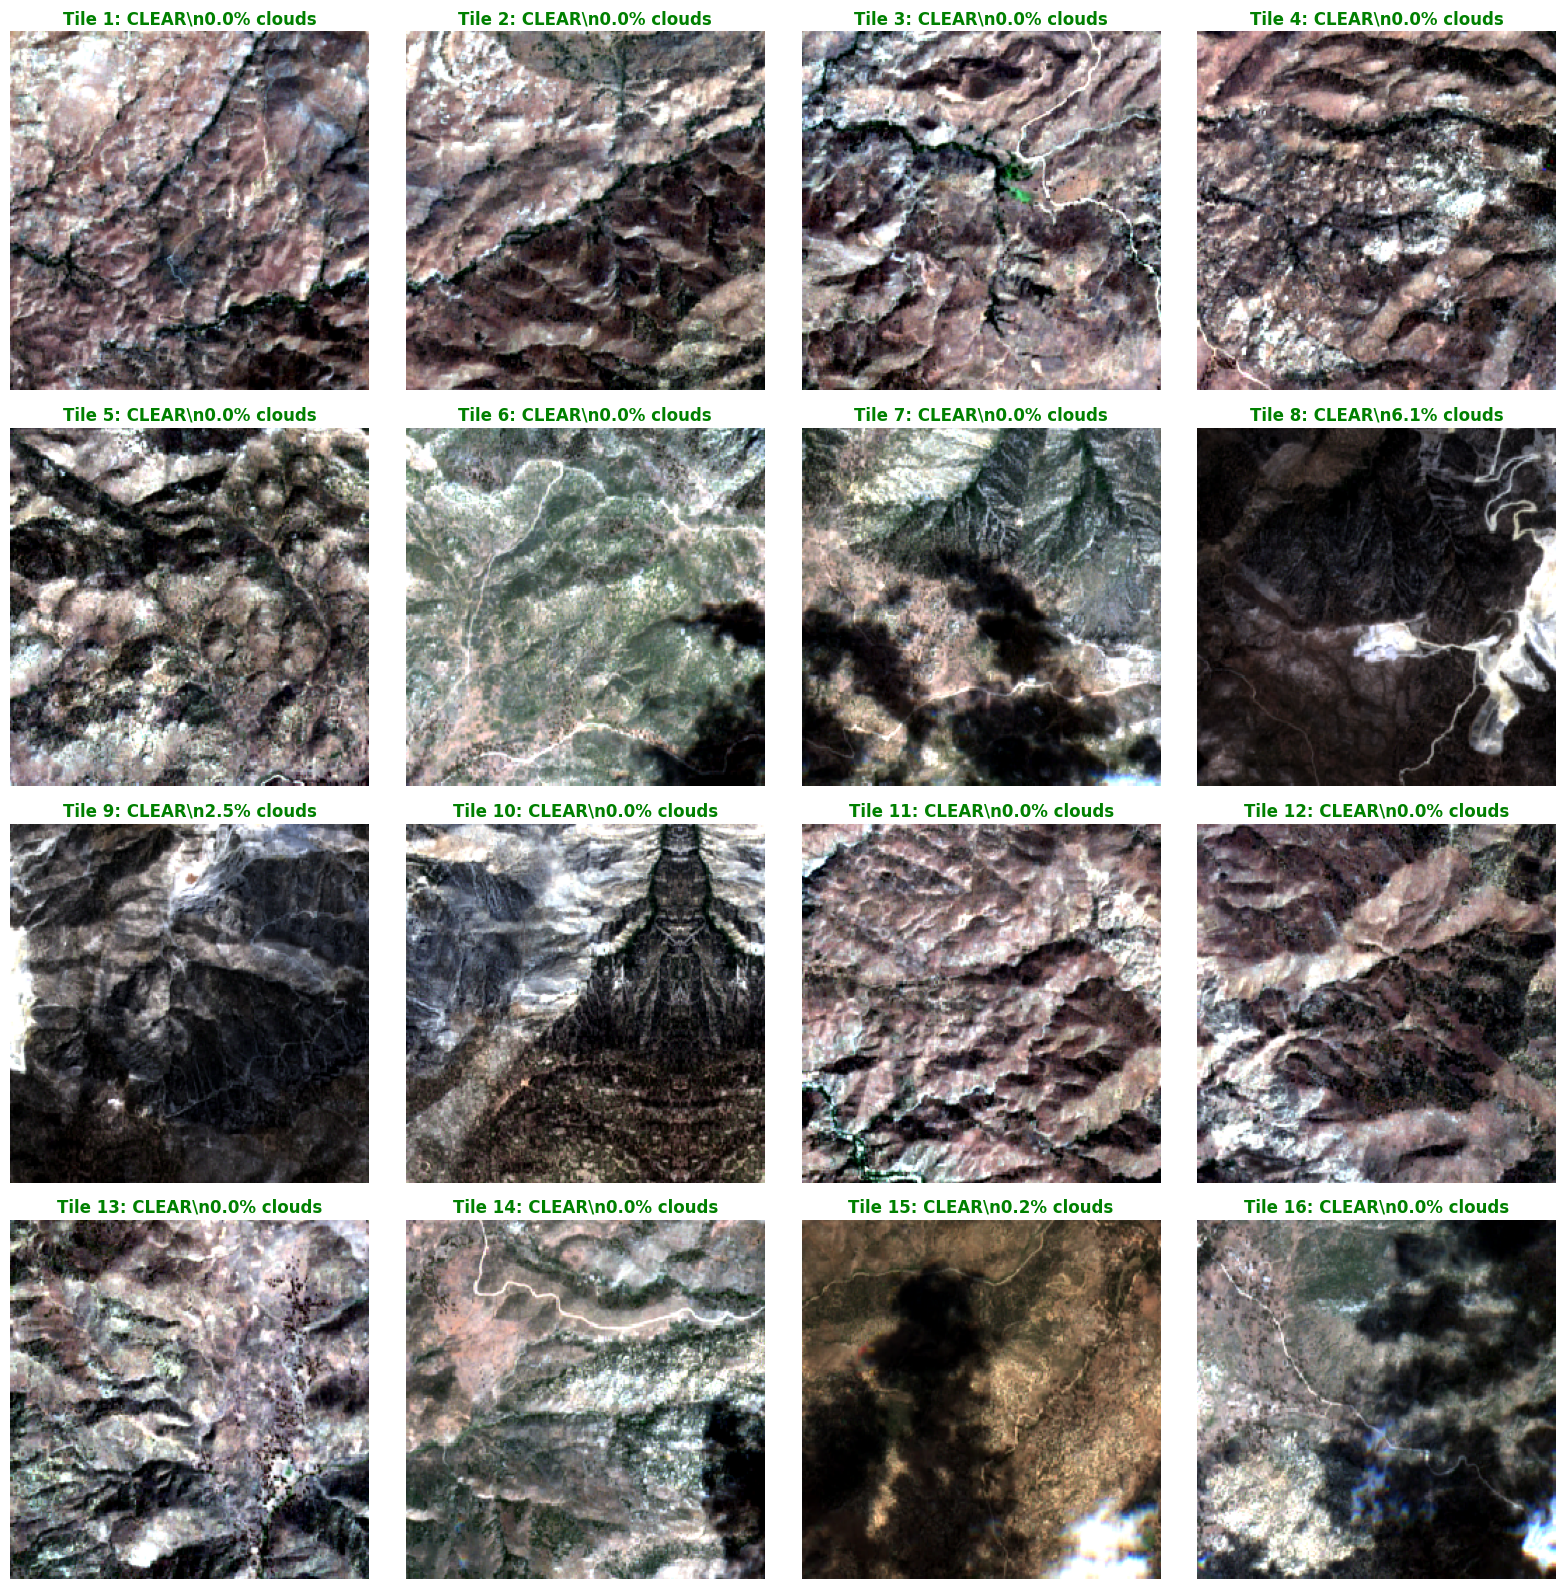

\n2. Creating cloud coverage heatmap...


TypeError: eval() arg 1 must be a string, bytes or code object

In [9]:
# Generate visualizations
print("Creating visualizations...")

# 1. Show grid of first 16 tiles
print("\\n1. Creating tile grid visualization...")
visualize_tile_grid(processed_tiles, results, max_tiles_to_show=16)

# 2. Create cloud coverage heatmap
print("\\n2. Creating cloud coverage heatmap...")
create_cloud_coverage_map(results)